In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import mlutils
%matplotlib inline
import pandas as pd
from IPython.display import Image
print tf.__version__

1.9.0


vamos a experimentar con este dataset sintético.

In [7]:
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression

In [11]:
X_data,y_data = make_moons(300, noise=.2)

In [4]:
make_moons?

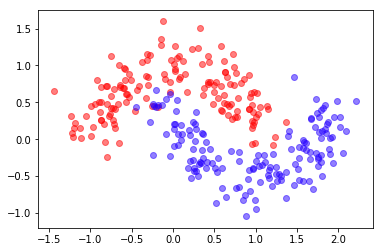

In [12]:
mlutils.plot_2Ddata(X_data,y_data)

## Regresión logística, un modelo de clasificación

En este caso $y^{(i)} \in [0,1]$, sólo puede tener dos valores posibles, y nuestro modelo representa una frontera de clasificación (un **hiperplano**)

defnimos un modelo lineal, como en regresion, pero hacemos pasar la salida por una función sigmoide

$$ \hat y^{(i)} = \text{sigm}(b+\overline{\theta} \dot \;  \mathbf{x}^{(i)})$$

donde:

$$\text{sigm}(z) = \frac{1}{e^{-z}+1}$$

con esto garantizamos que:

- la salida $\hat y^{(i)}$ la podamos interpretar como una función de  probabilidad ya que $0 \le \hat y^{(i)} \le 1$
- la función de predicción sea contínua, lo que garantiza que sea derivable y por tanto, que **podamos usar algoritmos de optimización**

observa que 

- $\overline{\theta} \dot \;  \mathbf{x}^{(i)} \in \mathbb{R}$, y por tanto puede alcanzar cualquier valor
- en este caso, en vez de forzar una columna de 1's sobre $X$, añadimos $b$, un término separado de bias

Experimenta con distintos valores de `k`

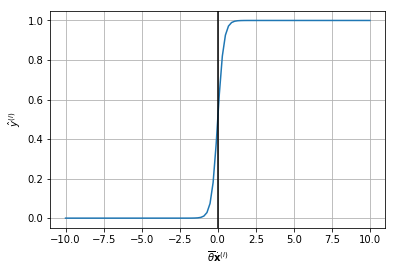

In [13]:
x = np.linspace(-10,10, 100)
k = 5.
sigm = lambda x: 1./(np.exp(-k*x)+1)

plt.plot(x, sigm(x))
plt.grid()
plt.xlabel(r"$\overline{\theta} \dot  \mathbf{x}^{(i)}$")
plt.ylabel(r"$\hat y^{(i)}$")
plt.axvline(0, color="black")

### Medición del error

necesitamos una expresión **compacta** que nos mida el error **para cada caso** de la clasificación. Fíjate en la función $log$ para cualquier valor entre 0 y 1.

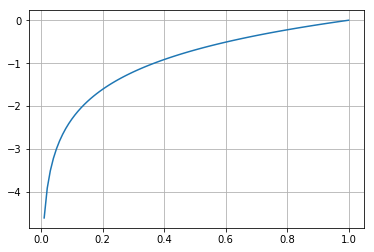

In [14]:
x = np.linspace(1e-2,1,100)
plt.plot(x, np.log(x))
plt.grid();

definimos la siguiente función de error para cualquier predicción $\hat y^{(i)}$ respecto al valor deseado



$$\text{err}^{(i)} = - [ y^{(i)}\log(\hat y^{(i)})+(1-y^{(i)})\log(1-\hat y^{(i)}) ]$$

observa que:

- si $y^{(i)}=0$:
    - el primer término desaparece ($=0$)
    - si la predicción es cerca de ser correcta el segundo término tiende a 0, si no, tiende a $-\infty$
- si $y^{(i)}=1$ 
    - el segundo término desaparece ($=0$)
    - si la predicción es cerca de ser correcta el primer término tiende a 0, si no, tiende a $-\infty$


Por tanto, definimos nuestra función de error global como

$$
\begin{align}
J(\overline \theta) &= \frac{1}{m}\sum_{i=0}^{m-1} \text{err}^{(i)}\\
&=-\frac{1}{m}\sum_{i=0}^{m-1}  y^{(i)}\log(\hat y^{(i)})+(1-y^{(i)})\log(1-\hat y^{(i)})
\end{align}$$

recueda que $ \hat y^{(i)} = \text{sigm}(\overline{\theta} \dot \;  \mathbf{x}^{(i)})$. **Intenta obtener manualmente $\nabla J$**

TensorFlow calcula **simbólicamente** $\nabla J$

## Ejercicio 1

define el grafo de TensorFlow para el $J(\overline \theta)$ (**loss**) anterior.

- usa [`tf.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/sigmoid)
- usa [`tf.log`](https://www.tensorflow.org/api_docs/python/tf/log)

In [60]:
X_data,y_data = make_moons(300, noise=.2)
print y_data.shape
print X_data.shape

(300,)
(300, 2)


In [61]:
tf.reset_default_graph()
t = tf.Variable(initial_value=tf.random_uniform([2,1]), name="t", dtype=tf.float32) 
b = tf.Variable(initial_value=tf.random_uniform([1,]), name="b", dtype=tf.float32)
X = tf.placeholder(name="X", dtype=tf.float32, shape = (None, 2))
y = tf.placeholder(name="y", dtype=tf.float32, shape = (None, 1))

y_hat = tf.sigmoid(b + tf.matmul(X,t))
loss  = -(tf.reduce_mean(y*tf.log(y_hat) + (1-y)*tf.log(1-y_hat)))

$$\text{err}^{(i)} = - [ y^{(i)}\log(\hat y^{(i)})+(1-y^{(i)})\log(1-\hat y^{(i)}) ]$$


### comprueba tu código 

In [62]:
# parametros de ejemplo
nt = np.r_[[ 1.2435143, -2.2746413]].reshape(-1,1)
nb = np.r_[[-0.06055273]]

# obtenemos numericamente el loss
def sigm(z):
    return 1./(1+np.exp(-z))
ny_hat = sigm(X_data.dot(nt)+nb)
nloss = -np.mean(y_data*np.log(ny_hat)[:,0]+(1-y_data)*np.log(1-ny_hat)[:,0])

# lo obtenemos a partir de las expresiones de TF
with tf.Session() as sess:
     tf_nloss = sess.run(loss, feed_dict={X:X_data, y: y_data.reshape(-1,1), t:nt, b:nb})

(1,)

In [63]:
print "loss numerico", nloss
print "loss TF      ", tf_nloss

loss numerico 0.32639029930539826
loss TF       0.32639033


In [64]:
!rm -rf tmp
with tf.Session() as sess:
    writer = tf.summary.FileWriter("tmp", sess.graph)

## Ejercicio 2

completa la función que optimiza

In [33]:
tf.train.GradientDescentOptimizer?

In [65]:
def optimize(X_data, y_data, optimizer,  tf_params, 
             n_epochs = 300, batch_size = 3 ):
    init = tf.global_variables_initializer()


    n = X_data.shape[0]

    loss_hist = []

    with tf.Session() as sess:
        sess.run(init)

        for epoch in xrange(n_epochs):
            print ".",
            for i in range(n/batch_size+int((n%batch_size)!=0)):
                batch_init, batch_end = i*batch_size, np.min([(i+1)*batch_size, n])
                X_batch, y_batch = X_data[batch_init:batch_end], y_data[batch_init:batch_end]

                sess.run(optimizer, feed_dict={X: X_batch, y: y_batch})
                #sess.run(optimizer, feed_dict={X: X_batch, y: y_batch.reshape(-1,1)})

            # history
            #nloss = sess.run(loss, feed_dict={X: X_batch, y: y_batch.reshape(-1,1)})
            nloss = sess.run(loss, feed_dict={X: X_batch, y: y_batch})

                        
            loss_hist.append(nloss)
            if len(loss_hist)>2 and loss_hist[-2]-loss_hist[-1]<5e-6:
                print "small loss, stopping iteration"
                break

        nparams = sess.run(tf_params)
    return nparams, loss_hist


In [66]:
X_data,y_data = make_moons(300, noise=.2)
optimizer = tf.train.GradientDescentOptimizer(1e-3).minimize(loss)

(nt, nb),loss_hist  = optimize(X_data, y_data.reshape(-1,1), optimizer, [t, b])

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


Text(0,0.5,u'loss')

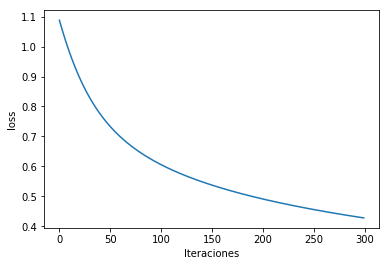

In [67]:
plt.plot(loss_hist)
plt.xlabel('Iteraciones')
plt.ylabel('loss')

### Ejercicio 3: Predicción

obtén las predicciones alimentando los valores de $\theta$ y $b$ obtenidos a una nueva sesión de tenrsorflow

In [68]:
def predict(X_data, fit_b, fit_t):
    with tf.Session() as sess:
        probs = sess.run(y_hat, feed_dict={X:X_data, t:fit_t, b:fit_b})[:,0]
    return probs>.5

In [69]:
nb

array([-0.21843871], dtype=float32)

accuracy 0.83


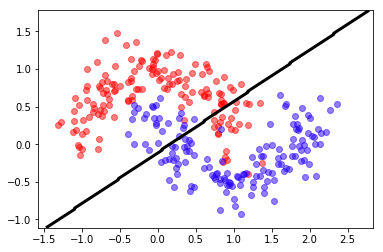

In [70]:
preds = predict(X_data, nb, nt)
print "accuracy", np.mean(preds==y_data)
mlutils.plot_2D_boundary(lambda X: predict(X, nb, nt), np.min(X_data, axis=0), np.max(X_data, axis=0))
mlutils.plot_2Ddata(X_data,y_data)

### Ejercicio 4: probemos ahora con el siguiente modelo

define nuevamente un grafo de tensorflow para optimizar el siguiente modelo cúbico

- $X \in \mathbb{R}^{m \times 2} = \{\mathbf{x}^{(0)},..,\mathbf{x}^{(m-1)}\}\;\;\;\text{with }\mathbf{x}^{(i)}\in\mathbb{R}^2$
- $y \in \mathbb{R}^{m \times 2}$, el modelo ofrecerá una medida de probabilidad para cada clase
- $W_1 \in \mathbb{R}^{2\times 5}$
- $b_1 \in \mathbb{R}^5$
- $W_2 \in \mathbb{R}^{5\times 2}$
- $b_2 \in \mathbb{R}^2$

$$
\begin{align}
L1 &= \text{tanh}(\mathbf{x}^{(i)}\cdot W_1+b_1)\\
\text{logits}^{(i)}&=L1\cdot W_2+b_2\\
\hat{y}^{(i)} &= \text{arg_max}(\text{logits}^{(i)})\\
\text{loss} &= \frac{1}{m}\sum_{i=0}^{m-1}\text{softmax_cross_entropy}(\text{logits}^{(i)}, y^{(i)})
\end{align}$$

para `softmax` y `loss` usa el siguiente código:

        softmax = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits = logits)
        loss    = tf.reduce_mean(softmax)

estas dos funciones son simplemente la generalización del sigmoide que vimos anteriormente para una tarea de clasificación multiclase (no solo binario), que garantiza que todas las salidas están entre 0 y 1 y pueden ser interpretadas como una función de probabilidad.

dada una salida $\mathbf{z} \in \mathbf{R}^n$ = $[z_0,..,z_{n-1}]$:

$$\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=0}^{n-1} e^{z_j}}$$


la figura siguiente muestra el _cross entropy_, que simplemente penaliza fallos en una codificación **one hot**

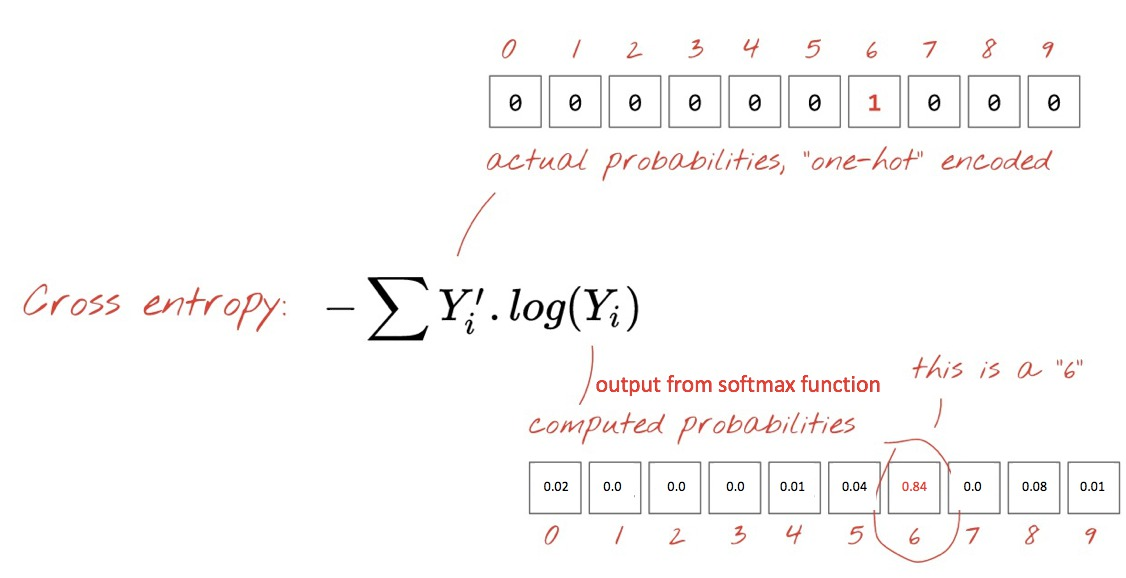

In [5]:
from IPython.display import Image
Image(filename='imgs/cross_entropy.jpg', width=600)

observa cómo establecemos la variable de salida de modo que $\in \mathbb{R}^2$

In [105]:
X_data,y_data = make_moons(300, noise=.2)
print y_data[:5]
y_data = np.eye(2,2)[y_data]
y_data[:5]


[1 0 0 1 0]


array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [106]:
print y_data[0:5]

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [111]:
tf.reset_default_graph()
X = tf.placeholder(name ="X",dtype = tf.float32, shape = (None,2))
y = tf.placeholder(name = "y", dtype = tf.float32, shape = (None,2))
    

with tf.name_scope("weights_biases"):
    W1 = tf.Variable(initial_value=tf.random_uniform([2,5]), name = "W1", dtype = tf.float32)
    b1 = tf.Variable(initial_value=tf.random_uniform([5,]), name="b1", dtype =  tf.float32)
    W2 = tf.Variable(initial_value=tf.random_uniform([5,2]), name="W2", dtype =  tf.float32)
    b2 = tf.Variable(initial_value=tf.random_uniform([2,]), name="b2", dtype =  tf.float32)
    
with tf.name_scope("loss"):
    # cross entropy 
    L1 = tf.tanh(b1 + tf.matmul(X,W1))
    logits = tf.add(b2,tf.matmul(L1,W2))
    softmax = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits = logits)
    loss = tf.reduce_mean(softmax)

In [112]:
optimizer = tf.train.GradientDescentOptimizer(1e-1).minimize(loss)
(nW1, nb1, nW2, nb2), loss_hist = optimize(X_data, y_data, optimizer, [W1, b1, W2, b2], 
                                           n_epochs=100, batch_size=10)

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


Text(0,0.5,u'loss')

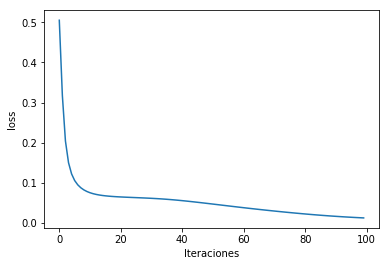

In [113]:
plt.plot(loss_hist)
plt.xlabel('Iteraciones')
plt.ylabel('loss')

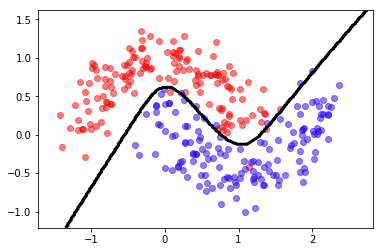

In [114]:
import mlutils
def predict(X):
    return np.argmax((np.tanh(X.dot(nW1)+nb1).dot(nW2)+nb2),axis=1)

mlutils.plot_2D_boundary(predict, np.min(X_data, axis=0), np.max(X_data, axis=0))
mlutils.plot_2Ddata(X_data,np.argmax(y_data, axis=1))
